California

In [15]:
from keras import models
from keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D, Input
from keras import optimizers, regularizers
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.datasets import california_housing
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [3]:
# Load the data
(inputs, targets), (x_test, y_test) = california_housing.load_data(
    version="small", test_split=0.2, seed=2025
)

# Names of the features, they are not included in the dataset but are available from the source
feature_names = [
    "MedInc", "HouseAge", "AveRooms", "AveBedrms",
    "Population", "AveOccup", "Latitude", "Longitude"
]

# Further split the training data into training and validation sets
# Split inputs and targets with a 80/20 ratio for training/validation
x_train, x_val, y_train, y_val = train_test_split(
    inputs, targets, test_size=0.2, random_state=2025
)

print("TRAINING",x_train.shape, y_train.shape)  # Training set
print("VALIDATION",x_val.shape, y_val.shape)      # Validation set
print("TEST",x_test.shape, y_test.shape)    # Test set

TRAINING (384, 8) (384,)
VALIDATION (96, 8) (96,)
TEST (120, 8) (120,)


- Training set: 64% of the entire dataset.
- Validation set: 16% of the entire dataset.
- Test set: 20% of the entire dataset.

In [4]:
# Normalize input features
mean = x_train.mean(axis=0)  # Compute mean from training set
std = x_train.std(axis=0) + 1e-8  # Add small epsilon to avoid division by zero
x_train = (x_train - mean) / std
x_test = (x_test - mean) / std
x_val = (x_val - mean) / std

# Scale target values
y_train /= 1e5
y_test /= 1e5
y_val /= 1e5

print(x_train.mean(axis=0))  # Should be close to 0
print(x_train.std(axis=0))   # Should be close to 1

[ 3.1362459e-04  5.7689642e-04 -8.5681677e-08 -3.3061951e-08
  3.4614157e-08  4.6566129e-09 -4.6566129e-10  1.8874805e-07]
[0.9999997  1.         0.9999992  0.9999999  1.0000001  0.99999994
 1.         1.        ]


### Model

Mallinnuksessa kokeilin erilaisia tasojen kokoja ja batch sizejä. Huomasin, että suuri batch size luo epävarmuutta tässä tapauksessa(16 tuotti luotettavasti ainakin 0.05 pistettä huonomman MAE:n). Huomasin myös, että aluksi koittamani Adam optimizer oli huonompi, kuin Huber optimizer.

Layereiden suurentaminen tai lisääminen nykyistä suuremmaksi antaa huonompia tuloksia. 4 Dense layeriä näyttää olevan tässä tapauksessa sopivin ratkaisu.


Model: "sequential_31"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_93 (Dense)                │ (None, 128)            │         1,152 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_38 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_94 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_39 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_95 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_40 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_96 (Dense)                │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_97 (Dense)                │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,033 (47.00 KB)

 Trainable params: 12,033 (47.00 KB)

 Non-trainable params: 0 (0.00 B)

Test MAE: 0.294


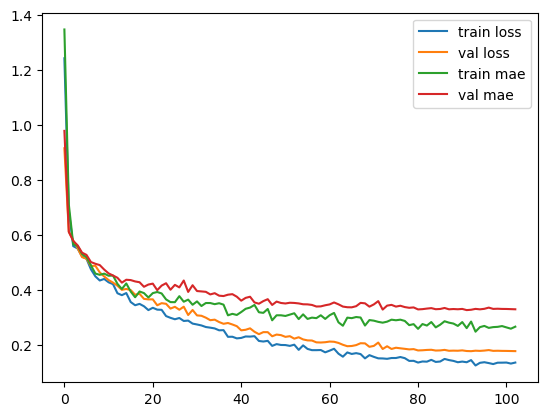

In [41]:
earlyStop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
lrScaler = ReduceLROnPlateau(monitor='val_loss', factor=0.15, patience=5)

l2_reg = regularizers.l2(0.002)

basic_model = models.Sequential([
    Input(shape=(8,)),
    Dense(128, activation='relu', kernel_regularizer=l2_reg),
    Dropout(0.2),
    Dense(64, activation='relu', kernel_regularizer=l2_reg),
    Dropout(0.2),
    Dense(32, activation='relu', kernel_regularizer=l2_reg),
    Dropout(0.2),
    Dense(16, activation='relu', kernel_regularizer=l2_reg),
    Dense(1, activation='linear'),
])

adam = optimizers.Adam(learning_rate=0.0005)

basic_model.compile(optimizer=adam, loss='huber', metrics=['mae'])
basic_model.summary()
basic_model.fit(x_train, y_train, epochs=500, verbose=0, batch_size=8, validation_data=(x_val, y_val), callbacks=[earlyStop, lrScaler])

# Evaluate the model
loss, mae = basic_model.evaluate(x_test, y_test, verbose=0)
print(f"Test MAE: {mae:.3f}")

# Plot the training history
history = basic_model.history.history
plt.figure()
plt.plot(history['loss'], label='train loss')
plt.plot(history['val_loss'], label='val loss')
plt.plot(history['mae'], label='train mae')
plt.plot(history['val_mae'], label='val mae')
plt.legend()
plt.show()

COMBINED (480, 8) (480,)
Final Test MAE: 0.294


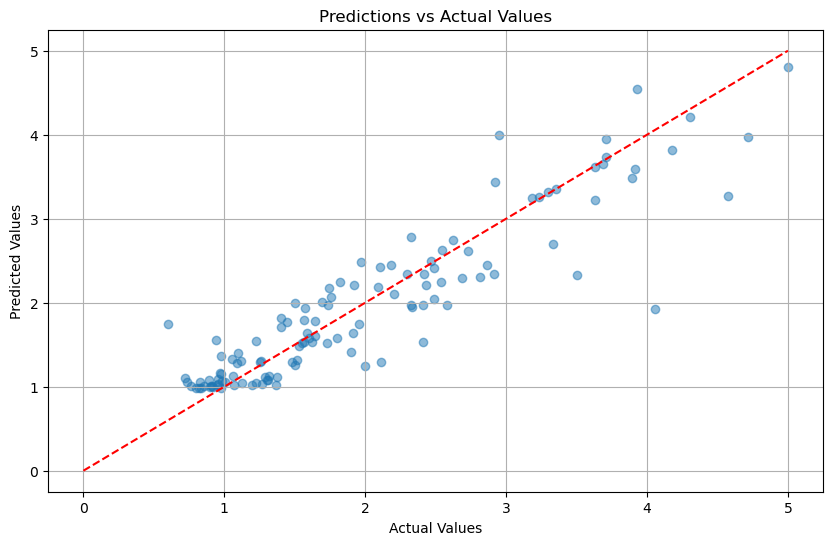

In [42]:
import numpy as np

# Combine training and validation sets

# Combine inputs
x_combined = np.vstack((x_train, x_val))
y_combined = np.append(y_train, y_val)

print("COMBINED", x_combined.shape, y_combined.shape)

earlyStop = EarlyStopping(monitor='loss', patience=10, restore_best_weights=True)
lrScaler = ReduceLROnPlateau(monitor='loss', factor=0.15, patience=5)

# Compile the model
basic_model.compile(optimizer=adam, loss='huber', metrics=['mae'])

# Train with the combined dataset
basic_model.fit(
    x_combined, y_combined, 
    epochs=500, 
    verbose=0, 
    batch_size=8, 
    callbacks=[earlyStop, lrScaler]
)

# Evaluate on test set
loss, mae = basic_model.evaluate(x_test, y_test, verbose=0)
print(f"Final Test MAE: {mae:.3f}")

# Plot predictions vs actual values
y_pred = basic_model.predict(x_test, verbose=0)
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([0, 5], [0, 5], 'r--')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Predictions vs Actual Values')
plt.grid(True)
plt.show()